# CÀI ĐẶT CÁC THƯ VIỆN CẦN THIẾT

In [3]:
!pip install inference_sdk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 4.2 MB/s eta 0:00:00


In [4]:
!pip install pytesseract
!sudo apt update
!sudo apt install tesseract-ocr

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Ign:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy Release [5,713 B]
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy Release.gpg [793 B]
Hit:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:10 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,595 kB]
Hit:11 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [2,602 kB]
Hit:13 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:14 https://ppa.launchpadconten

# PHÁT HIỆN BIỂN SỐ XE VÀ TIỀN XỬ LÝ ẢNH

- Model Type:
Roboflow 3.0 Object Detection (Fast)
- Dataset: https://universe.roboflow.com/licenseplate-vejey/plate-detect-bkwoo







## 01: Lấy dự đoán từ model

In [743]:
file = '0111_05692_b.jpg'

In [744]:
from inference_sdk import InferenceHTTPClient
import cv2
CLIENT = InferenceHTTPClient(api_url="https://detect.roboflow.com", api_key="8PKnBAYVuzxib2KznYlV")
result = CLIENT.infer(file, model_id="plate-detect-bkwoo/1")
plates = result.get('predictions', [])

In [745]:
print(plates)

[{'x': 305.5, 'y': 167.0, 'width': 97.0, 'height': 70.0, 'confidence': 0.8785005807876587, 'class': '0', 'class_id': 0, 'detection_id': '2984c881-a32a-4bbe-a42b-a3bd8d07c778'}]


In [746]:
def display(im_data):
    dpi = 80
    height, width  = im_data.shape[:2]
    figsize = width / float(dpi), height / float(dpi)
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])
    ax.axis('off')
    ax.imshow(im_data, cmap='gray')

    plt.show()

In [747]:
img = cv2.imread(file)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_copy = img.copy()

In [ ]:
plate = plates[0]
x_0, y_0, w, h = plate['x'], plate['y'], plate['width'], plate['height']
x_1, y_1 = x_0 - w / 2, y_0 - h / 2
x_2, y_2 = x_1 + w, y_1 + h
cv2.rectangle(img_copy, (int(x_1)+5, int(y_1)), (int(x_2)-5, int(y_2)), (0, 255, 0), 1)

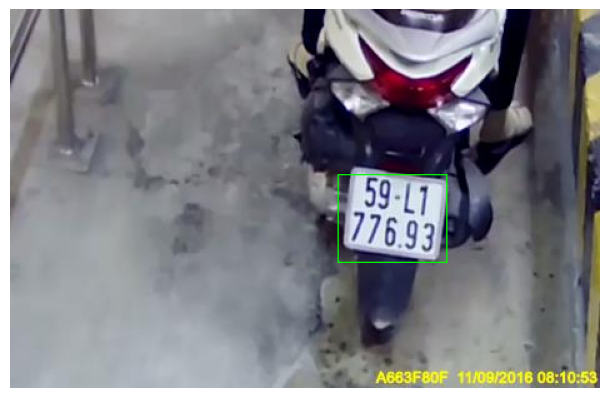

In [749]:
display(img_copy)

In [750]:
x1, y1, x2, y2 = (int(x_1), int(y_1), int(x_2), int(y_2))
crop = img[y1-8:y2, x1:x2+5]
resize = cv2.resize(crop, None, fx=3, fy=3, interpolation=cv2.INTER_CUBIC)

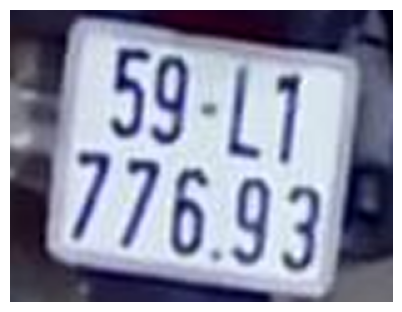

In [751]:
display(resize)

## 02: Tìm góc xoay ảnh

* Làm mờ ảnh
* Tìm cạnh (canny)
* Tìm đường thẳng (HoughLinesP)



In [752]:
import numpy as np
import math

def compute_skew(src_img):

    if len(src_img.shape) == 3:
        h, w, _ = src_img.shape
    elif len(src_img.shape) == 2:
        h, w = src_img.shape
    else:
        print('upsupported image type')

    img = cv2.medianBlur(src_img, 3)

    edges = cv2.Canny(img,  threshold1 = 30,  threshold2 = 100, apertureSize = 3, L2gradient = True)
    lines = cv2.HoughLinesP(edges, 1, math.pi/180, 30, minLineLength=w / 4.0, maxLineGap=h/4.0)
    angle = 0.0
    nlines = lines.size

    cnt = 0
    for x1, y1, x2, y2 in lines[0]:
        ang = np.arctan2(y2 - y1, x2 - x1)
        if math.fabs(ang) <= 30:
            angle += ang
            cnt += 1

    if cnt == 0:
        return 0.0
    return (angle / cnt)*180/math.pi

In [753]:
def rotate_image(image, angle):
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    return result

def deskew(src_img):
    return rotate_image(src_img, compute_skew(src_img))

In [754]:
rotated = deskew(resize)

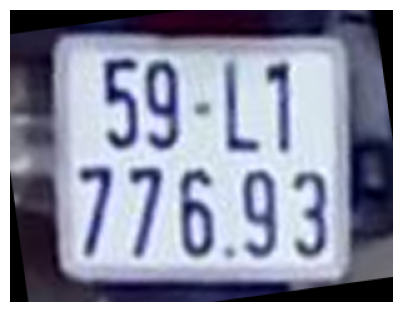

In [755]:
display(rotated)

## 03: Tiền xử lý ảnh: Lấy mức xàm và làm mờ lọc nhiễu

In [756]:
gray = cv2.cvtColor(rotated, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (9,9), 0)

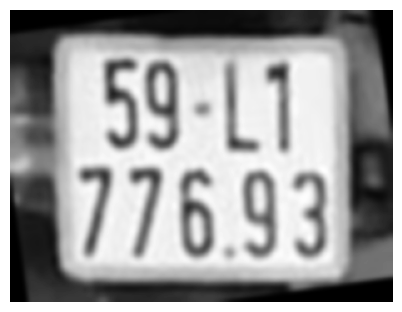

In [757]:
display(blur)

## 04: Tiền xử lý ảnh: Nhị phân hóa

In [758]:
_, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)

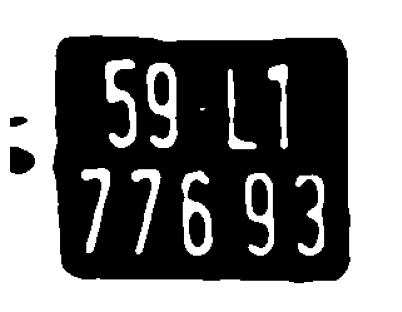

In [759]:
display(thresh)

## 05: Tiền xử lý ảnh: Tăng độ dày chữ để tạo cạnh

In [938]:
rect_kern = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 5))
dilation = cv2.dilate(thresh, rect_kern, iterations=1)

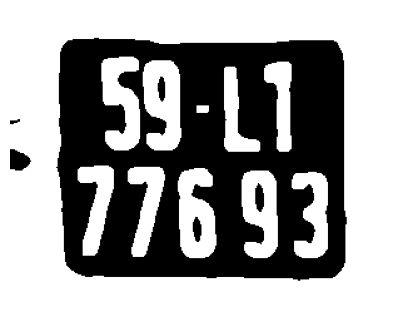

In [939]:
display(dilation)

# ĐỌC BIỂN SỐ XE
- Sử dụng **pytesseract** để đọc ký tự


## 01: Tìm contours, sắp xếp từ trái sang phải và lấy countor chứa biển số xe

In [956]:
cnts, _ = cv2.findContours(dilation, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
plate_cnt = sorted(cnts, key=cv2.contourArea, reverse=True)[1]
cnts = sorted(cnts, key=lambda ctr: cv2.boundingRect(ctr)[0])

## 02: Lọc contour không hợp lệ và phân loại biển
* Lọc viền ngoài của biển
* Lọc các contour có kích cỡ nhỏ
* Phân loại biển dài và biển ngắn





In [957]:
top_half, bottom_half = [], []
rois = []

In [958]:
height = cv2.boundingRect(plate_cnt)[-1]

img_copy = rotated.copy()
for cnt in cnts:
    x, y, w, h = cv2.boundingRect(cnt)
    if height / h > 3 or height / h < 1.5:
        continue
    roi = dilation[y-5:y + h +5, x-6:x+6 + w]
    roi = cv2.bitwise_not(roi)
    roi = cv2.medianBlur(roi, 5)
    cv2.rectangle(img_copy, (x - 5, y - 5), (x + w + 5, y + h + 5), (0, 255, 0), 1)
    if width / height >= 3.5:
        rois.append(roi)
    else:
        if y < height / 2 - 20:
            top_half.append(roi)
        else:
            bottom_half.append(roi)

In [959]:
if (top_half and bottom_half):
    rois = top_half + bottom_half

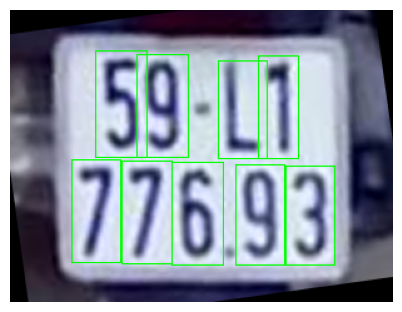

In [960]:
display(img_copy)

## 03: Đọc ký tự

In [961]:
max_height = max(roi.shape[0] for roi in rois)
_rois = [cv2.resize(roi, (roi.shape[1], max_height)) for roi in rois]

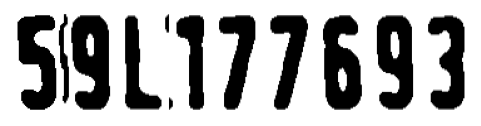

In [962]:
display(cv2.hconcat(_rois))

In [963]:
import pytesseract
plate_num = ''
for roi in _rois:
    char = pytesseract.image_to_string(roi, config='-c tessedit_char_whitelist=0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ --psm 8 --oem 3').strip()
    plate_num += char

In [964]:
print(plate_num)

59L177693
